Start by loading the appropriate packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Proceed to load the MNIST dataset, which comes bundled with TensorFlow

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

We now code our model graph

In [19]:
from google.colab import files
uploaded = files.upload()

Saving Screen Shot 2018-04-03 at 8.39.46 AM.png to Screen Shot 2018-04-03 at 8.39.46 AM.png


In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


#cv2.imread('/desktop/Screen Shot 2018-04-03 at 8.39.46 AM', 1)

In [0]:
init_param = lambda shape: tf.random_normal(shape, dtype=tf.float32)

with tf.name_scope("IO"):
    inputs = tf.placeholder(tf.float32, [None, 784], name="X")
    targets = tf.placeholder(tf.float32, [None, 10], name="Yhat")

with tf.name_scope("LogReg"):
    W = tf.Variable(init_param([784, 10]), name="W")
    B = tf.Variable(init_param([10]))
    logits = tf.matmul(inputs, W) + B
    y = tf.nn.softmax(logits)

MNIST has images of size 28x28, which have to be flattened before being fed to the model, becoming a 784x1 vector. Also, we are dealing with 10 classes, therefore our parameters have to reflect these dimensions, w has to take a $\mathbb{R}^{784}$ vector and output a $\mathbb{R}^{10}$ vector, therefore it has to be a 784x10 matrix. b has to sum with this vector, therefore it must have the same length (10x1). Finally, we compute the softmax of our logits ($wx+b$).

Now we can define our objective function and other metrics. TensorFlow already has a negative log-likelihood cost (same as cross entropy) implemented, so we use it. We also implement an accuracy calculation which simply compares our highest ranking class against the ground truth in order to evaluate our model.

In [0]:
with tf.name_scope("train"):
    learning_rate = tf.Variable(0.5, trainable=False)
    cost_op = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    cost_op = tf.reduce_mean(cost_op) 
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(targets,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100


Our training routine is pretty standard, much likely we have been implementing so far. With the exception that here we use the built-in functions from the MNIST dataset to create and load the mini-batches.

In [11]:
tolerance = 1e-4

# Perform Stochastic Gradient Descent
epochs = 1
last_cost = 0
alpha = 0.7
max_epochs = 100
batch_size = 50
costs = []
sess = tf.Session()
print "Beginning Training"
with sess.as_default():
    init = tf.initialize_all_variables()
    sess.run(init)
    sess.run(tf.assign(learning_rate, alpha))
    #writer = tf.train.SummaryWriter("/tmp/tboard", sess.graph) # Create TensorBoard files
    while True:

        num_batches = int(mnist.train.num_examples/batch_size)
        cost=0
        for _ in range(num_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            tcost, _ = sess.run([cost_op, train_op], feed_dict={inputs: batch_xs, targets: batch_ys})
            cost += tcost
        cost /= num_batches

        tcost = sess.run(cost_op, feed_dict={inputs: mnist.test.images, targets: mnist.test.labels})
            
        costs.append([cost, tcost])
        
        # Keep track of our performance
        if epochs%5==0:
            acc = sess.run(accuracy, feed_dict={inputs: mnist.train.images, targets: mnist.train.labels})
            print "Epoch: %d - Error: %.4f - Accuracy - %.2f%%" %(epochs, cost, acc)

            # Stopping Condition
            if abs(last_cost - cost) < tolerance or epochs > max_epochs:
                print "Converged."
                break

            last_cost = cost
            
        epochs += 1
    
    tcost, taccuracy = sess.run([cost_op, accuracy], feed_dict={inputs: mnist.test.images, targets: mnist.test.labels})
    print "Test Cost: %.4f - Accuracy: %.2f%% " %(tcost, taccuracy)


Beginning Training
Epoch: 5 - Error: 0.3679 - Accuracy - 90.96%
Epoch: 10 - Error: 0.3173 - Accuracy - 92.16%
Epoch: 15 - Error: 0.3001 - Accuracy - 92.16%
Epoch: 20 - Error: 0.2896 - Accuracy - 92.85%
Epoch: 25 - Error: 0.2844 - Accuracy - 91.40%
Epoch: 30 - Error: 0.2798 - Accuracy - 92.54%
Epoch: 35 - Error: 0.2742 - Accuracy - 91.99%
Epoch: 40 - Error: 0.2705 - Accuracy - 93.04%
Epoch: 45 - Error: 0.2723 - Accuracy - 92.29%
Epoch: 50 - Error: 0.2693 - Accuracy - 93.12%
Epoch: 55 - Error: 0.2662 - Accuracy - 92.91%
Epoch: 60 - Error: 0.2662 - Accuracy - 92.95%
Converged.
Test Cost: 0.3198 - Accuracy: 91.82% 


Plot train curves

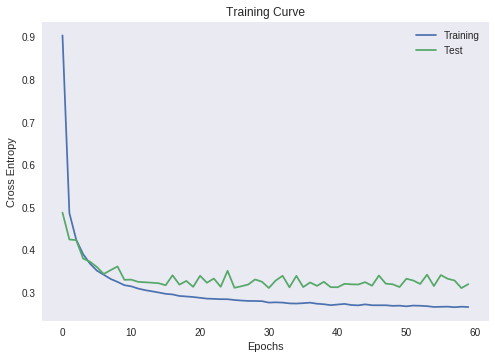

In [12]:
epochs = len(costs)
costs = np.array(costs)
plt.plot(range(epochs), costs[:,0], label="Training")
plt.plot(range(epochs), costs[:,1], label="Test")
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.title("Training Curve")
plt.legend(loc='best')
plt.show()

